# Bivariate luminsoity functions

The aim in this notebook is to plot the bivariate luminosity functions available from the CIGALE samples. We have shows that the standard HELP data can recreate the Gruppioni LF. Now we want to look at the two dimansional properties of the HELP galaxies in dust luminosity, star formation raten stellar mass space.

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
import glob

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
from astropy.cosmology import z_at_value
from astropy.constants import iau2015 as const
Lsun= const.L_sun.value

import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

from pcigale.sed import SED
from pcigale.sed_modules import get_module

from lf.lf import plot_LF, volume



In [5]:
FIELD = 'COSMOS'
#FILTERS_DIR = "/opt/herschelhelp_python/database_builder/filters/"
#DMU_DIR = '/mnt/hedam/dmu_products/'
DMU_DIR = '/Users/rs548/GitHub/dmu_products/'
final_cat = 'spire_objects.fits'
ldust_loc = 'dmu28/dmu28_{}/data/{}_Ldust_prediction_results.fits'.format(FIELD, FIELD)
xid_sample_loc = 'dmu28/dmu28_{}/data/zphot/{}_cigale_allxid_extcor_20190402_results_KM.fits'.format(FIELD, FIELD)

In [13]:
catalogue = Table.read(DMU_DIR + 'dmu32/dmu32_{}/data/'.format(FIELD)
                       + final_cat)['help_id',
                                           'ra', 
                                           'dec', 
                                           'f_irac_i1', 
                                           'f_mips_24',
                                           'redshift', 
                                           'cigale_dustlumin',
                                        'cigale_sfr',
                                        'cigale_mstar',
                                         ] #ELAIS-N1_20171016.fits

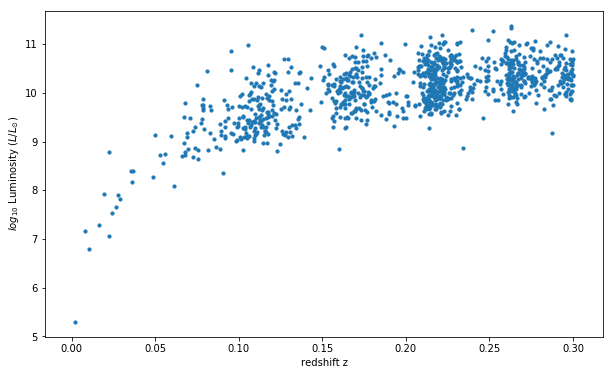

L_centre_values,dN_by_dL
float64,float64
2.152642592828666e+35,0.000936724850136212
6.807253581629026e+35,0.002584068552099895
2.152642592828666e+36,0.005749552528422267
6.807253581629026e+36,0.005151986675749166
2.152642592828666e+37,0.0011951317053462015
6.807253581629027e+37,6.460171380249738e-05
2.1526425928286657e+38,0.0
6.807253581629027e+38,0.0
2.1526425928286658e+39,0.0


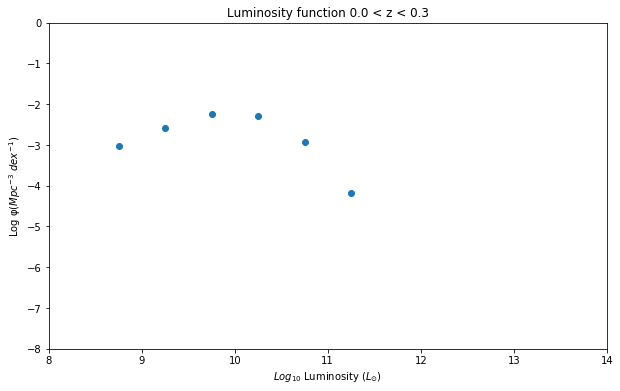

In [18]:
plot_LF(0.,0.3,10**8.75 * Lsun, 10**14.25 * Lsun, catalogue, bin_width=0.5, 
        show_sample=True, show_LF=True, vmax=False, moc = cosmos_moc)

In [6]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
import glob

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
from astropy.cosmology import z_at_value
from astropy.constants import iau2015 as const
Lsun= const.L_sun.value

import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

from pcigale.sed import SED
from pcigale.sed_modules import get_module

DMU_DIR = '/Users/rs548/GitHub/dmu_products/'

cosmo = FlatLambdaCDM(H0=100. , Om0 = (1-0.7))
#cosmo = Planck15

dV_z0  = cosmo.comoving_volume(0)
dV_z1  = cosmo.comoving_volume(1)
dV_z2  = cosmo.comoving_volume(2)


en1_moc = MOC(filename=DMU_DIR + 'dmu2/dmu2_field_coverages/'
                       +'ELAIS-N1_MOC.fits')

servs_moc = MOC(filename=DMU_DIR + 'dmu0/dmu0_DataFusion-Spitzer/data/'
                       +'DF-SERVS_ELAIS-N1_MOC.fits')

field_moc = MOC(filename=DMU_DIR + 'dmu2/dmu2_field_coverages/'
                       +'{}_MOC.fits'.format(FIELD))

cosmos_moc = MOC(filename=DMU_DIR + 'dmu0/dmu0_COSMOS2015/data/COSMOS2015-HELP_selected_20160613_MOC.fits')
area = cosmos_moc.area


In [ ]:


#print(volume(0.,1.,cosmo))

def bivariate(table,
              z1, z2,                               
              #Take all inputs in log space!
              d1_min, d1_max, d1_bin_width, d1_name, #first dimension
              d2_min, d2_max, d2_bin_width, d2_name, #second dimension
              cosmo=cosmo, 
              show_sample=False, 
              show_LF = False,
              vmax=False, 
              eff_area=False,
              moc = en1_moc):
    """Plot a general two dimensional galaxy statistics function
    
    Take a catalogue as input with two columns and plot a 2d distribution with 
    volume weighting.
    
    The function creates a two dimensional array and loops over the elements 
    counting the volume weighted galaxy numbers in each bin.
    
    It expects all inputs in logspace
    
    Inputs
    ------
    table: astropy.table.Table
        The table of galaxy properties
        
    z1: float
        The lower redshift bound
        
    z2: float
        The upper redshift bound
      
    Outputs
    ------
    densities: np.array
        Array of volume weighted galaxy counts
    """
    z = table['redshift']
    d1 = table[d1_name]
    d2 = table[d2_name]
    
    

    #Make redshift bin mask
    mask_z = (  (x > z1) 
                & (x < z2))


    #Apply redshift mask to redshifts and both columns
    z = z[mask_z]
    d1 = d1[mask_z]
    d2 = d2[mask_z]
    
    try:
        d1_unit = d1.unit
    except:
        d1_unit = 'Unknown unit'
        
    try:
        d2_unit = d2.unit
    except:
        d2_unit = 'Unknown unit'


    if show_sample:
        plt.scatter(z,np.log10(d1), s = 10)
        plt.xlabel('redshift z')
        plt.ylabel('$log_{10}$ Dimension 1 ($L/L_{\odot}$)')
        plt.show()

    #use 20 bins if widths not provided
    d1_nbins = 20 
    d2_nbins = 20 
    if d1_bin_width is not None:
        d1_nbins = int((d1_max - d1_min )/ d1_bin_width)
    if d2_bin_width is not None:
        d2_nbins = int((d2_max - d2_min )/ d2_bin_width)

  
    
    has_both = ~np.isnan(d1)& ~np.isnan(d2)
    
    z  = z[has_both]
    d1 = d1[has_both]
    d2 = d2[has_both]

    #Get rid of unused rows
    table = table[mask_z & has_both]

    if vmax:
        #Calculate 1/Vmax values by taking the element wise minimum of zmax and z2
        volume_correction = 1/( volume(z1,np.minimum(table['z_max'], z2),cosmo, moc) )
    elif eff_area:
        #Caluclate 1/Vmax using effective area measure used by Gruppioni
        volume_correction = moc.area_sq_deg/table['eff_area']
    else:
        #Return array of 1s to apply no volume correction
        volume_correction = np.full(len(table), 1.)

    #make an empty array to be filled with densities in n per volume per dex squared
    densities = np.full([d1_nbins, d2_nbins], np.nan)
    
    bin_edges = np.full([d1_nbins, d2_nbins, 2, 2], np.nan)
    #Just filling the bin edge values with a brute force double loop
    for g_bin in 
    

    #Again brute force double loop to calculate numbers
    for gal_bin in np.arange(nbins):
        L=galaxy_bins['L_centre_values'][gal_bin]
        #print(L)
        #Get the array of zmaxes for this L bin
        mask = ((galaxy_sample > (L) ) 
                               & (galaxy_sample < galaxy_bins['L_centre_values'][gal_bin+1]))
        z_max_bin = z_max[mask]
        if len(z_max_bin) == 0:
            continue
        
        #Apply volume correction
        dN_by_dL = np.sum( (( u.megaparsec)**3 ) * volume_correction[mask]
            
        #Test for max effect
        #dN_by_dL = np.sum( (( u.megaparsec)**3 ) / ( volume(z1,np.minimum(redshifts[mask], z2),cosmo, moc) ) )
            
        #Disallow volume corrections greater than a factor of two
        if( np.sum(volume(z1,np.minimum(z_max_bin, z2),cosmo, moc))/ 
            np.sum(volume(z1,np.full(len(z_max_bin), z2),cosmo, moc))) < 0.5:
            continue
        #print(dN_by_dL)
        #print(np.sum(np.minimum(z_max_bin, z2) != z2)/len(z_max_bin))
        
        binwidth = galaxy_bins['L_centre_values'][gal_bin+1] - galaxy_bins['L_centre_values'][gal_bin]
        log_binwidth = (np.log10(galaxy_bins['L_centre_values'][gal_bin+1]/Lsun) 
                            - np.log10(galaxy_bins['L_centre_values'][gal_bin]/Lsun))
        dN_by_dL= dN_by_dL / (log_binwidth)
        
        galaxy_bins['dN_by_dL'][gal_bin] = dN_by_dL
        
        

        
        

    
    if show_LF:
        plt.scatter( np.log10(np.array(galaxy_bins['L_centre_values'])/Lsun), 
                    np.log10(np.array(galaxy_bins['dN_by_dL'])))
        #plt.xscale('log')
        plt.title('Luminosity function {} < z < {}'.format(z1, z2))
        plt.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
        plt.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
        plt.ylim([-8.,0.])
        plt.xlim([8.,14.])
        #plt.plot(np.array([1,2,3,4]), np.array([5,6,5,6]))
    
        #plt.savefig('Luminosity Functions')
    return densities #, d1_bin_edges, d2_bin_edges
    
    

test = bivariate(final_cat,
                 0.8, 1.,
                 8. , 14., 0.5, 'cigale_dustlumin',
                 8. , 14., 0.5, 'cigale_sfr',
                 show_sample=True, show_LF=True, vmax=False, moc=cosmos_moc
              )    


In [23]:
test = np.full([2,3,2,2], np.nan)

In [24]:
test[0,1] = np.array([[1,2],[3,4]])
test

array([[[[nan, nan],
         [nan, nan]],

        [[ 1.,  2.],
         [ 3.,  4.]],

        [[nan, nan],
         [nan, nan]]],


       [[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]]])

In [25]:
for t in np.array([[1,2],[3,4]]):
    print(t)

[1 2]
[3 4]
